In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import torch
import json

from tqdm import tqdm
from skimage.color import rgb2lab, lab2rgb
from typing import List

from src.utils import *
from src.refine_transform import *
from src.find_transform import *
from src.visualize import *
from src.shape_align import *
from src.fragment_comparator import *

In [2]:
data_dir = '../../dataset'
palette = np.array([[4.83058360e+01, -4.28336049e+00, -1.04226657e+00],
                    [7.28763389e+01,  1.10190913e+01,  2.91083397e+01],
                    [1.93975643e+01,  8.21757008e+00, -6.52862709e+00],
                    [6.12470461e+01,  6.38868771e+00,  1.05191202e+01],
                    [8.70237508e+01,  2.60029629e+00,  6.34060233e+00],
                    [3.84328672e+01,  2.22768163e+01,  1.17465682e+00],
                    [3.29131583e+01,  3.06846260e-02, -6.19825618e+00]])

In [3]:
def parallel_comparison(idx1, idx2):
    comparator = FragmentComparator()
    return {(idx1, idx2): comparator.align_two_fragments_by_idx(idx1, idx2)}

In [4]:

class FragmentComparator:
    def __init__(self, blocks_num=6, data_dir="../../dataset") -> None:
        self.blocks_num = blocks_num
        self.data_dir = data_dir
        pass
    
    def pack_aligns_to_initial_params(
        self,
        alignments: List[Alignment], 
        descriptor1, 
        descriptor2, 
        fragments_shape
    ):
        """
        alignments: list of alignments from curvature matching
        descriptor1, descriptor2: shape descriptors of fragments
        fragments_shape: shape of fragments (assuming they have the same size)


        return: list of (angle, x, y), list of subcurves1, list of subcurves2 
        subcurves1[i] corresponds to subcurves2[i]
        """
        initial_params = []
        subcurves1 = []
        subcurves2 = []
        for alignment in alignments[:4]:
            line1 = aligned_coords2line(alignment.indices, descriptor1.edge_coords, left=True)
            line2 = aligned_coords2line(alignment.indices, descriptor2.edge_coords[::-1], left=False)
            line1 -= fragments_shape[0] // 2
            line2 -= fragments_shape[0] // 2
            best_transform_params = find_best_transform_ransac(line1, line2) # TODO: may be fix seed or increase number of iterations so that this step was more stable
    #         initial_params.append(best_transform_params)
            subcurves1.append(line1)
            subcurves2.append(line2)
            if best_transform_params is None:
                print("No best transform")
                continue
            cos = best_transform_params[0]
            cos = min(cos, 1)
            cos = max(cos, -1)
            theta, shift_x, shift_y = -np.rad2deg(np.arccos(cos)), best_transform_params[3], best_transform_params[2] # TODO: fix angle computation [0, pi] -> [-pi, pi]
            initial_params.append((theta, int(shift_x), int(shift_y)))
        return initial_params, subcurves1, subcurves2
    
    def align_two_frags_with_multiple_aligns(
            self,
            palette,
            frag1: Fragment, frag2, 
            to_print=None,
            blocks_num=6,
            verbose=0
            ):
        
        shape_dsc1 = fragment2shape_descriptor(palette, frag1)
        shape_dsc2 = fragment2shape_descriptor(palette, frag2)
        indices, pointer, score = align_two_fragments(
            palette,
            frag1, frag2,
            to_print=to_print,
            shape_descriptor1=shape_dsc1,
            shape_descriptor2=shape_dsc2,
            verbose=verbose
        )
        aligns = generate_multiple_alignments(pointer, score, shape_dsc1, shape_dsc2, blocks_num)
        return shape_dsc1, shape_dsc2, aligns
    
    def align_two_fragments_by_idx(
        self, 
        idx1, idx2,
        verbose=0
    ):
        print(f"Aligning {idx1} and {idx2}")
        start_time = time.time()
        frag1, frag2 = build_fragment_from_directory(self.data_dir + '/' + str(idx1)), build_fragment_from_directory(self.data_dir + '/' + str(idx2))
        pad_size = int(max([max(frag1.fragment.shape), max(frag2.fragment.shape)]) / 3) + 40
        frag1, frag2 = pad_fragment_to_size(frag1, pad_size), pad_fragment_to_size(frag2, pad_size)
        
        dsc1, dsc2, aligns = self.align_two_frags_with_multiple_aligns(
            None, # fix palette usage
            frag1, frag2,
            blocks_num=self.blocks_num,
            to_print=None,
            verbose=verbose
        )
        initial_params, subcurves1, subcurves2 = self.pack_aligns_to_initial_params(aligns, dsc1, dsc2, frag1.fragment.shape)
        alignments = match_two_aligned_fragments(
            frag1, frag2,
            initial_params,
            subcurves1,
            subcurves2,
#             feature_extractor,
            pad_size=pad_size,
            verbose=0
        )
        print(f"Alignment time: {time.time() - start_time}")
        return sorted(alignments, key=lambda x: x.confidence, reverse=True)
    
    def align_frags_and_save(
        self,
        frag_nums,
        existing_json='alignments_merged.json'        
    ):
        aligns = {}
        json_dict = None
        if existing_json is not None:
            json_dict = json.load(open(existing_json, 'r'))
        for i in range(len(frag_nums)):
            for j in range(i + 1, len(frag_nums)):
#                 aligns += self.align_two_fragments(frag_nums[i], frag_nums[j])
#                 print(f"Aligning {frag_nums[i]} and {frag_nums[j]}")

                if json_dict is not None:
                    if f"{frag_nums[i]}_{frag_nums[j]}" in json_dict:
                        continue
                translations = self.align_two_fragments_by_idx(frag_nums[i], frag_nums[j])
                print(f"Length: {len(translations)}")
    
                pair_aligns = []
                for tr in translations:
                    pair_aligns.append({
                        'x': tr.x,
                        'y': tr.y,
                        'angle': tr.angle,
                        'confidence': tr.confidence,
                        'geom_score': tr.geom_score
                    })

                aligns[f"{frag_nums[i]}_{frag_nums[j]}"] = pair_aligns
        with open('alignments1.json', 'w') as f:
            json.dump(aligns, f)

In [5]:
i1, i2 = 9, 15

In [9]:
comparator = FragmentComparator(blocks_num=6)

In [27]:
i1, i2 = 92, 93

In [28]:
# comparator = FragmentComparator(blocks_num=6)
translations = comparator.align_two_fragments_by_idx(i1, i2, verbose=0)

Aligning 92 and 93
Too far translations filtered out: 180
Alignment time: 62.5510950088501


In [29]:
pad_size=300
frag1 = pad_fragment_to_size(build_fragment_from_directory(data_dir + f'/{i1}'), pad_size)
frag2 = pad_fragment_to_size(build_fragment_from_directory(data_dir + f'/{i2}'), pad_size)
frag2.fragment = frag2.fragment / 255

3
Confidence = 0.7249337952375536, translation = Translation(x=-52, y=282, angle=2.9942754438866572, confidence=0.7249337952375536, geom_score=0.8856006972875267)
Confidence = 0.674014800237994, translation = Translation(x=-30, y=282, angle=7.994275443886657, confidence=0.674014800237994, geom_score=0.8257780466718254)
Confidence = 0.6246536819268059, translation = Translation(x=-70, y=290, angle=-2.0057245561133428, confidence=0.6246536819268059, geom_score=0.7342220297393204)


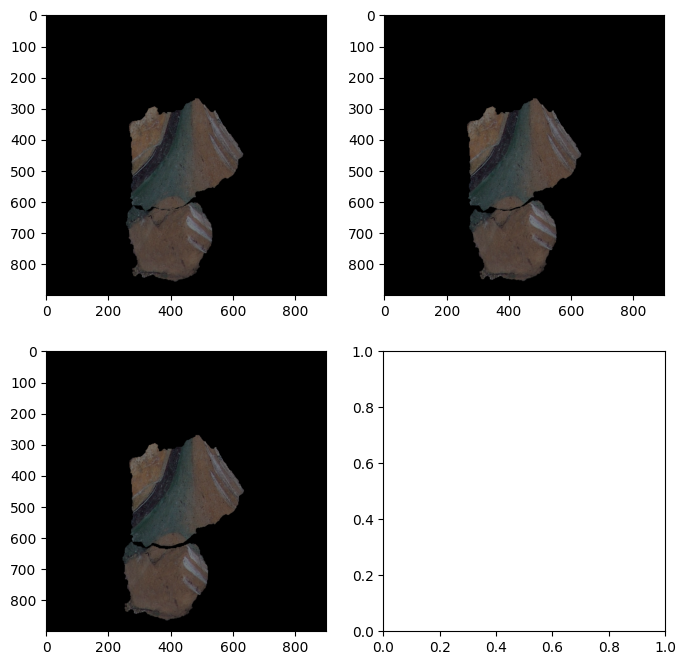

In [30]:
print(len(translations))
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
for i, tr in enumerate(translations[:4]):
    transformed = shift_fragment(rotate_fragment(frag1, tr.angle), tr.x, tr.y)
    blended = blend_fragments(frag2, transformed)
    axes[i // 2][i % 2].imshow(blended.fragment)
    print(f"Confidence = {tr.confidence}, translation = {tr}")

In [17]:
start_time = time.time()
comparator.align_two_fragments_by_idx(6, 7)
comparator.align_two_fragments_by_idx(7, 8)
comparator.align_two_fragments_by_idx(9, 11)
comparator.align_two_fragments_by_idx(10, 11)
print(f"Total time: {time.time() - start_time}")

Aligning 6 and 7
Too far translations filtered out: 479
Alignment time: 41.62002110481262
Aligning 7 and 8
Too far translations filtered out: 1504
Alignment time: 62.20706033706665
Aligning 9 and 11
Too far translations filtered out: 192
Alignment time: 52.31816029548645
Aligning 10 and 11
Aligning 6 and 7
Too far translations filtered out: 472
Alignment time: 71.46699476242065
Aligning 9 and 11
Too far translations filtered out: 206
Alignment time: 88.75402188301086
Too far translations filtered out: 1399
Alignment time: 78.1605875492096
Total time: 234.3067708015442


In [12]:
from concurrent.futures import ThreadPoolExecutor

In [13]:
start_time = time.time()
with ThreadPoolExecutor() as executor:
    r1 = executor.submit(parallel_comparison, 6, 7)
    r2 = executor.submit(parallel_comparison, 7, 8)
    r3 = executor.submit(parallel_comparison, 9, 11)
#     r4 = executor.submit(parallel_comparison, 10, 11)
    
print(r1.result())
print(r2.result())
print(r3.result())
# print(r4.result())
print(f"Total time: {time.time() - start_time}")

Aligning 6 and 7
Aligning 7 and 8
Aligning 9 and 11
Too far translations filtered out: 629
Alignment time: 169.1469144821167
Too far translations filtered out: 189
Alignment time: 172.27827739715576
Too far translations filtered out: 1564
Alignment time: 195.67429733276367
[Translation(x=-70, y=-68, angle=7.487816397204931, confidence=0.8115627463550033, geom_score=0.9505644459146783)]
[Translation(x=18, y=-204, angle=-0.43681809073047617, confidence=0.8713530573708131, geom_score=0.9530918151292899), Translation(x=-137, y=5, angle=-107.82582343661568, confidence=0.7560953670297927, geom_score=0.9073963444340518)]
[Translation(x=-113, y=277, angle=0.0, confidence=0.8779030076173625, geom_score=0.9149383345168534), Translation(x=-187, y=-267, angle=-142.04143843588076, confidence=0.5827203766223035, geom_score=0.860499092479256)]
Total time: 195.67641639709473


In [6]:
from joblib import Parallel, delayed

In [10]:
frag_nums = [3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 49, 53, 54, 59, 61, 65, 95, 96]
# frag_nums = [3, 5, 6]
frag_pairs = [(i1, i2) for i1 in frag_nums for i2 in frag_nums if i1 < i2]

In [11]:
start_time = time.time()
out_generator = Parallel(n_jobs=-1)(delayed(parallel_comparison)(i1, i2) for i1, i2 in frag_pairs)
print(time.time() - start_time)

/mnt/c/Users/dev/Documents/fresco/fresco-reassembling/code/src/refine_transform.py:27: RuntimeWarning: invalid value encountered in scalar divide
  too_small_ext_intersection = max(intersection / anchor_frag.extended_mask.sum(), intersection / transformed_frag.extended_mask.sum()) < 0.025
/mnt/c/Users/dev/Documents/fresco/fresco-reassembling/code/src/refine_transform.py:27: RuntimeWarning: invalid value encountered in scalar divide
  too_small_ext_intersection = max(intersection / anchor_frag.extended_mask.sum(), intersection / transformed_frag.extended_mask.sum()) < 0.025
/mnt/c/Users/dev/Documents/fresco/fresco-reassembling/code/src/refine_transform.py:27: RuntimeWarning: invalid value encountered in scalar divide
  too_small_ext_intersection = max(intersection / anchor_frag.extended_mask.sum(), intersection / transformed_frag.extended_mask.sum()) < 0.025
/mnt/c/Users/dev/Documents/fresco/fresco-reassembling/code/src/refine_transform.py:27: RuntimeWarning: invalid value encountered i

10478.18192076683


In [14]:
print(list(out_generator))

[{(3, 5): [Translation(x=-171, y=-89, angle=-138.13010235415595, confidence=0.8929000810830722, geom_score=0.901328252988229), Translation(x=-185, y=-71, angle=-133.13010235415595, confidence=0.8625241166263584, geom_score=0.8470523874732733), Translation(x=-161, y=-107, angle=-143.13010235415595, confidence=0.8613691318077983, geom_score=0.8578140906788033), Translation(x=-19, y=173, angle=-123.20492206728284, confidence=0.8190081053182457, geom_score=0.8444226894321822), Translation(x=-37, y=165, angle=-128.20492206728284, confidence=0.8082763282036158, geom_score=0.8827855433935999)]}, {(3, 6): [Translation(x=123, y=50, angle=-69.72882633717774, confidence=0.8517918598889944, geom_score=0.9297257369562122), Translation(x=-160, y=-103, angle=-120.00146970233826, confidence=0.8261904990519962, geom_score=0.9065027335713127), Translation(x=-168, y=-85, angle=-110.00146970233826, confidence=0.7940238633525064, geom_score=0.9052865709328405), Translation(x=-174, y=-65, angle=-105.0014697

In [16]:
alignments = {}
for res in out_generator:
    alignments.update(res)

In [18]:
aligns = {}
for i in range(len(frag_nums)):
    for j in range(i + 1, len(frag_nums)):
#                 aligns += self.align_two_fragments(frag_nums[i], frag_nums[j])
#                 print(f"Aligning {frag_nums[i]} and {frag_nums[j]}")

#         if json_dict is not None:
#             if f"{frag_nums[i]}_{frag_nums[j]}" in json_dict:
#                 continue
#         translations = self.align_two_fragments_by_idx(frag_nums[i], frag_nums[j])

        translations = alignments[(frag_nums[i], frag_nums[j])]
        print(f"Length: {len(translations)}")

        pair_aligns = []
        for tr in translations:
            pair_aligns.append({
                'x': tr.x,
                'y': tr.y,
                'angle': tr.angle,
                'confidence': tr.confidence,
                'geom_score': tr.geom_score
            })

        aligns[f"{frag_nums[i]}_{frag_nums[j]}"] = pair_aligns
with open('alignments/alignments2.json', 'w') as f:
    json.dump(aligns, f)

Length: 5
Length: 4
Length: 5
Length: 6
Length: 2
Length: 0
Length: 5
Length: 4
Length: 5
Length: 3
Length: 1
Length: 2
Length: 3
Length: 3
Length: 0
Length: 4
Length: 2
Length: 2
Length: 5
Length: 2
Length: 6
Length: 1
Length: 4
Length: 5
Length: 3
Length: 4
Length: 3
Length: 4
Length: 4
Length: 4
Length: 2
Length: 3
Length: 1
Length: 4
Length: 6
Length: 1
Length: 2
Length: 2
Length: 2
Length: 2
Length: 2
Length: 3
Length: 3
Length: 0
Length: 4
Length: 4
Length: 3
Length: 1
Length: 2
Length: 1
Length: 4
Length: 2
Length: 0
Length: 3
Length: 2
Length: 5
Length: 2
Length: 3
Length: 2
Length: 2
Length: 3
Length: 1
Length: 4
Length: 5
Length: 0
Length: 2
Length: 3
Length: 1
Length: 2
Length: 2
Length: 0
Length: 3
Length: 2
Length: 4
Length: 2
Length: 1
Length: 0
Length: 3
Length: 2
Length: 1
Length: 4
Length: 3
Length: 6
Length: 4
Length: 3
Length: 1
Length: 4
Length: 6
Length: 3
Length: 2
Length: 1
Length: 4
Length: 1
Length: 1
Length: 3
Length: 1
Length: 2
Length: 7
Length: 1
Length: 1


In [13]:
print(time.time() - start_time)

10478.2162835598


In [23]:
comparator = FragmentComparator(blocks_num=5)
# comparator.align_frags_and_save([20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 37])
# comparator.align_frags_and_save([3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 20, 21, 22, 23, 24, 25, 26, 28,  29, 30, 31, 32, 33, 34, 37])
comparator.align_frags_and_save(
    [3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15],
    existing_json=None
)


Aligning 3 and 5
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 1818/1818 [00:03<00:00, 567.39it/s]


17
5
theta = -136.16286469046284, x_initial = 34, y_initial = 152


100%|█████████████████████████████████████████████████████████████████████████████████| 135/135 [00:02<00:00, 57.48it/s]


theta = -140.60599656178593, x_initial = -162, y_initial = -87


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 276.39it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 58.14it/s]


theta = -117.66342121351923, x_initial = -20, y_initial = 141


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 299.57it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 300.29it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 297.38it/s]
0it [00:00, ?it/s]


theta = -128.5743314045058, x_initial = -108, y_initial = -146


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 272.38it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 232.66it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 248.34it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 249.13it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 214.55it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 193.19it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 264.24it/s]
0it [00:00, ?it/s]


Too far translations filtered out: 2016
Alignment time: 65.73392939567566
Length: 5
Aligning 3 and 6
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 1818/1818 [00:03<00:00, 486.82it/s]


14
5
theta = -55.796757903889336, x_initial = 168, y_initial = 55


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 291.75it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 276.53it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 228.17it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 246.64it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 256.72it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 269.27it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 286.31it/s]
0it [00:00, ?it/s]


theta = -115.00146970233826, x_initial = -162, y_initial = -85


100%|█████████████████████████████████████████████████████████████████████████████████| 144/144 [00:02<00:00, 49.38it/s]


theta = -69.72882633717774, x_initial = 113, y_initial = 40


100%|███████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 57.13it/s]


theta = -116.6331187491559, x_initial = -90, y_initial = -135


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 275.37it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 273.23it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 269.48it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 273.82it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 274.27it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 275.59it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 274.62it/s]
0it [00:00, ?it/s]


Too far translations filtered out: 1474
Alignment time: 59.46277737617493
Length: 4
Aligning 3 and 7
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 1818/1818 [00:07<00:00, 236.88it/s]


4
3
theta = -56.22134486293237, x_initial = 205, y_initial = 100


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 224.56it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 220.59it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 225.31it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 213.83it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 226.98it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 229.41it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 218.96it/s]
0it [00:00, ?it/s]


theta = -90.0, x_initial = -32, y_initial = -180


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 241.14it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 236.59it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 242.41it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 240.55it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 242.62it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 242.77it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 237.57it/s]
0it [00:00, ?it/s]


theta = -168.51198907410276, x_initial = -52, y_initial = -194


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 226.63it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 226.74it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 232.37it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 232.38it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 227.65it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 225.47it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 225.33it/s]
0it [00:00, ?it/s]


Alignment time: 23.791929244995117
Length: 0
Aligning 3 and 8
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 1818/1818 [00:04<00:00, 382.29it/s]


18
7
theta = -114.66832857940435, x_initial = -169, y_initial = 106


100%|███████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 57.73it/s]


theta = -180.0, x_initial = -125, y_initial = 65


100%|███████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 65.40it/s]


theta = -32.942609529561544, x_initial = -8, y_initial = 211


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 66.00it/s]


theta = -172.04812456934116, x_initial = -181, y_initial = 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 272.56it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 274.66it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 272.99it/s]
0it [00:00, ?it/s]


Too far translations filtered out: 2682
Alignment time: 81.63055682182312
Length: 7
Aligning 3 and 9
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 1818/1818 [00:10<00:00, 169.22it/s]


12
5
theta = -55.69234854420456, x_initial = 77, y_initial = -258


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 164.88it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 173.97it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 173.55it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 172.55it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 170.00it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 171.91it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 172.98it/s]
0it [00:00, ?it/s]


theta = -180.0, x_initial = 63, y_initial = -307


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 53.66it/s]


theta = -62.19743899677856, x_initial = 170, y_initial = 134


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 182.04it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 179.40it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 182.62it/s]
0it [00:00, ?it/s]


theta = -56.9318013668001, x_initial = 243, y_initial = 74


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 175.57it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 168.61it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 174.55it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 174.93it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 175.35it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 176.55it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 170.44it/s]
0it [00:00, ?it/s]


Too far translations filtered out: 314
Alignment time: 65.46222066879272
Length: 5
Aligning 3 and 10
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 1818/1818 [00:05<00:00, 355.65it/s]


8
2
theta = -61.103986035202176, x_initial = -35, y_initial = -166


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 260.97it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 286.22it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 280.03it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 282.98it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 282.18it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 274.91it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 280.55it/s]
0it [00:00, ?it/s]


theta = -0.0, x_initial = 116, y_initial = -118


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 264.40it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 275.66it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 279.67it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 277.75it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 273.58it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 277.12it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 275.58it/s]
0it [00:00, ?it/s]


Alignment time: 15.816333055496216
Length: 0
Aligning 3 and 11
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 1818/1818 [00:08<00:00, 227.21it/s]


23
5
theta = -61.59693743422133, x_initial = 8, y_initial = -200


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 197.64it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 194.84it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 198.50it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 197.34it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 195.77it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 194.38it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 198.54it/s]
0it [00:00, ?it/s]


theta = -180.0, x_initial = -78, y_initial = -236


100%|█████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 48.92it/s]


theta = -9.867758683018065, x_initial = 176, y_initial = 191


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 173.07it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 176.60it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 176.53it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 171.44it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 172.17it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 90/90 [00:02<00:00, 33.29it/s]


theta = -136.18665830708986, x_initial = 59, y_initial = 156


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 166.43it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 156.72it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 161.50it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 161.64it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 167.74it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 164.16it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 167.15it/s]
0it [00:00, ?it/s]


Too far translations filtered out: 192
Alignment time: 47.0053493976593
Length: 4
Aligning 3 and 12
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 1818/1818 [00:02<00:00, 621.54it/s]


11
4
theta = -157.44763729922215, x_initial = -28, y_initial = 140


100%|█████████████████████████████████████████████████████████████████████████████████| 171/171 [00:03<00:00, 56.04it/s]


theta = -40.91207249706633, x_initial = 129, y_initial = 108


100%|███████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 49.91it/s]


theta = -143.48619584509888, x_initial = -93, y_initial = 109


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 262.59it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 255.16it/s]
0it [00:00, ?it/s]


theta = -94.8622842250472, x_initial = -74, y_initial = -89


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 268.57it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 283.99it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 278.83it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 285.09it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 286.52it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 286.46it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 280.66it/s]
0it [00:00, ?it/s]


Too far translations filtered out: 2598
Alignment time: 80.40064835548401
Length: 5
Aligning 3 and 14
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 1818/1818 [00:07<00:00, 246.92it/s]


17
4
theta = -76.46289787449265, x_initial = -89, y_initial = -154


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 214.18it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 212.49it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 215.75it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 213.13it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 201.77it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 210.91it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 210.82it/s]
0it [00:00, ?it/s]


theta = -78.61929853992484, x_initial = 160, y_initial = 111


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 211.44it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 46.70it/s]


theta = -147.20162105322763, x_initial = -253, y_initial = -85


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 201.59it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 48.47it/s]


theta = -60.67187220776588, x_initial = 22, y_initial = 202


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 219.38it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 222.48it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 224.97it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 223.36it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 210.97it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 222.89it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 221.65it/s]
0it [00:00, ?it/s]


Too far translations filtered out: 97
Alignment time: 48.38594698905945
Length: 4
Aligning 3 and 15
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 1818/1818 [00:07<00:00, 241.93it/s]


11
5
theta = -100.63689007030283, x_initial = -263, y_initial = 74


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 213.84it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 241.76it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 238.67it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 238.43it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 239.17it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 239.46it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 235.26it/s]
0it [00:00, ?it/s]


theta = -101.7090039588457, x_initial = 207, y_initial = 48


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 252.67it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 249.36it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 250.10it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 239.12it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 250.62it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 243.24it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 249.30it/s]
0it [00:00, ?it/s]


theta = -17.416393490063356, x_initial = -216, y_initial = -202


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 222.67it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 223.98it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 225.48it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 224.22it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 226.24it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 220.53it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 225.50it/s]
0it [00:00, ?it/s]


theta = -5.122739846707536, x_initial = 35, y_initial = 241


100%|███████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 61.43it/s]


Too far translations filtered out: 121
Alignment time: 37.1297287940979
Length: 3
Aligning 5 and 6
new diag score is estimated


100%|████████████████████████████████████████████████████████████████████████████████| 764/764 [00:01<00:00, 535.29it/s]


11
4
theta = -25.345799913186006, x_initial = 64, y_initial = 37


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 549.71it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 540.60it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 513.99it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 549.76it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 546.87it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 544.13it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 118.80it/s]


theta = -55.68616619392652, x_initial = -17, y_initial = 106


100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [00:01<00:00, 105.26it/s]


theta = -112.61986494804043, x_initial = 63, y_initial = -114


100%|████████████████████████████████████████████████████████████████████████████████| 162/162 [00:01<00:00, 114.07it/s]


theta = -134.5249277043886, x_initial = -29, y_initial = -105


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 539.93it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 533.84it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 510.01it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 518.26it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 537.96it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 511.34it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 521.86it/s]
0it [00:00, ?it/s]


Too far translations filtered out: 1654
Alignment time: 33.49406719207764
Length: 4
Aligning 5 and 7
new diag score is estimated


100%|████████████████████████████████████████████████████████████████████████████████| 764/764 [00:03<00:00, 231.71it/s]


21
7
theta = -0.0, x_initial = 193, y_initial = -64


100%|█████████████████████████████████████████████████████████████████████████████████| 198/198 [00:04<00:00, 46.89it/s]


theta = -9.510861633103646, x_initial = -102, y_initial = -50


100%|█████████████████████████████████████████████████████████████████████████████████| 153/153 [00:03<00:00, 45.65it/s]


theta = -74.68667512823708, x_initial = -79, y_initial = 159


100%|███████████████████████████████████████████████████████████████████████████████████| 90/90 [00:01<00:00, 45.66it/s]


theta = -85.53755361879958, x_initial = -85, y_initial = -73


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 241.70it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 242.04it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 241.90it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 241.75it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 242.27it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 238.51it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 242.33it/s]
0it [00:00, ?it/s]


Too far translations filtered out: 2008
Alignment time: 85.14427089691162
Length: 2
Aligning 5 and 8
new diag score is estimated


100%|████████████████████████████████████████████████████████████████████████████████| 764/764 [00:01<00:00, 387.35it/s]


10
3
theta = -3.73955433966131, x_initial = -97, y_initial = 25


100%|█████████████████████████████████████████████████████████████████████████████████| 216/216 [00:02<00:00, 72.38it/s]


theta = -86.63935526828065, x_initial = -6, y_initial = 101


100%|█████████████████████████████████████████████████████████████████████████████████| 135/135 [00:01<00:00, 76.21it/s]


theta = -164.96188209779976, x_initial = -100, y_initial = 54


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 363.58it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 361.02it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 367.72it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 342.70it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 365.61it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 368.55it/s]
0it [00:00, ?it/s]


Too far translations filtered out: 2038
Alignment time: 44.854483127593994
Length: 2
Aligning 5 and 9
new diag score is estimated


100%|████████████████████████████████████████████████████████████████████████████████| 764/764 [00:04<00:00, 171.31it/s]


16
7
theta = -118.12445628630134, x_initial = 45, y_initial = -199


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 181.75it/s]
0it [00:00, ?it/s]


theta = -28.616070223227002, x_initial = 215, y_initial = -94


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 173.61it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 173.08it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 173.19it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 174.17it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 174.65it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 174.73it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 167.84it/s]
0it [00:00, ?it/s]


theta = -117.43061820050805, x_initial = 143, y_initial = 45


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 189.81it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 189.86it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 187.80it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 190.74it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 190.16it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 187.06it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 184.32it/s]
0it [00:00, ?it/s]


theta = -8.991874994594497, x_initial = 192, y_initial = -26


100%|█████████████████████████████████████████████████████████████████████████████████| 216/216 [00:05<00:00, 37.74it/s]


Too far translations filtered out: 920
Alignment time: 79.85221076011658
Length: 1
Aligning 5 and 10
new diag score is estimated


100%|████████████████████████████████████████████████████████████████████████████████| 764/764 [00:02<00:00, 359.27it/s]


19
5
theta = -17.944116103192524, x_initial = 98, y_initial = 108


100%|█████████████████████████████████████████████████████████████████████████████████| 162/162 [00:01<00:00, 81.87it/s]


theta = -47.51949049059029, x_initial = 122, y_initial = -49


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 391.64it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 395.21it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 368.87it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 387.10it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 385.53it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 379.22it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 388.50it/s]
0it [00:00, ?it/s]


theta = -117.0009925438333, x_initial = -50, y_initial = -119


100%|███████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 96.65it/s]


theta = -27.1636885635477, x_initial = -51, y_initial = -139


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 374.04it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 353.48it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 301.50it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 323.28it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 327.49it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 329.24it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 307.99it/s]
0it [00:00, ?it/s]


Too far translations filtered out: 1909
Alignment time: 46.99231767654419
Length: 4
Aligning 5 and 11
new diag score is estimated


100%|████████████████████████████████████████████████████████████████████████████████| 764/764 [00:03<00:00, 227.51it/s]


20
5
theta = -112.42942038486972, x_initial = -107, y_initial = -143


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 169.42it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 165.02it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 170.81it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 177.47it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 177.89it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 182.05it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 181.00it/s]
0it [00:00, ?it/s]


theta = -115.71452928800531, x_initial = -41, y_initial = -137


100%|███████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 35.80it/s]


theta = -58.55324254714243, x_initial = 57, y_initial = 117


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 197.25it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 189/189 [00:05<00:00, 37.48it/s]


theta = -149.5559056477126, x_initial = -31, y_initial = 153


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 203.43it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 195.24it/s]
0it [00:00, ?it/s]


Too far translations filtered out: 1403
Alignment time: 84.24930357933044
Length: 3
Aligning 5 and 12
new diag score is estimated


100%|████████████████████████████████████████████████████████████████████████████████| 764/764 [00:01<00:00, 681.28it/s]


11
4
theta = -123.80965537864343, x_initial = 66, y_initial = 42


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 630.17it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 664.14it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 626.54it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 499.27it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 564.67it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 653.95it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 638.49it/s]
0it [00:00, ?it/s]


theta = -63.17355945745751, x_initial = 99, y_initial = 36


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [00:01<00:00, 113.37it/s]


theta = -80.12067566662236, x_initial = -22, y_initial = 86


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [00:01<00:00, 129.40it/s]


theta = -28.813817290446746, x_initial = 70, y_initial = 47


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 591.48it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 579.60it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 600.24it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 562.06it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 616.18it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 651.00it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 635.78it/s]
0it [00:00, ?it/s]


Too far translations filtered out: 2341
Alignment time: 32.443692445755005
Length: 3
Aligning 5 and 14
new diag score is estimated


100%|████████████████████████████████████████████████████████████████████████████████| 764/764 [00:03<00:00, 251.58it/s]


13
6
theta = -129.9603478029826, x_initial = 19, y_initial = -142


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 220.43it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 240.87it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 205.26it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 235.25it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 223.77it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 230.61it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 232.84it/s]
0it [00:00, ?it/s]


theta = -121.54286083694733, x_initial = 183, y_initial = 20


100%|███████████████████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 42.24it/s]


theta = -104.58910673169238, x_initial = 161, y_initial = 24


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 207.96it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 215.29it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 225.70it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 224.14it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 226.97it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 225.63it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 225.55it/s]
0it [00:00, ?it/s]


theta = -126.82740517216746, x_initial = 101, y_initial = -141


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 218.23it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 223.58it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 224.19it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 223.90it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 226.13it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 217.76it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 225.06it/s]
0it [00:00, ?it/s]


Too far translations filtered out: 618
Alignment time: 42.99673843383789
Length: 1
Aligning 5 and 15
new diag score is estimated


100%|████████████████████████████████████████████████████████████████████████████████| 764/764 [00:03<00:00, 251.39it/s]


5
2
theta = -104.1127978061159, x_initial = -87, y_initial = -159


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 258.44it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 262.39it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 260.79it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 263.91it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 258.42it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 263.14it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 257.94it/s]
0it [00:00, ?it/s]


theta = -113.60322575536165, x_initial = 154, y_initial = 14


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:02<00:00, 51.65it/s]


Alignment time: 31.503801345825195
Length: 0
Aligning 6 and 7
new diag score is estimated


100%|████████████████████████████████████████████████████████████████████████████████| 842/842 [00:03<00:00, 255.05it/s]


18
7
theta = -82.95429145901961, x_initial = 105, y_initial = -172


100%|█████████████████████████████████████████████████████████████████████████████████| 162/162 [00:03<00:00, 46.40it/s]


theta = -8.490213451143111, x_initial = -67, y_initial = -63


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 258.62it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 258.46it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 162/162 [00:03<00:00, 46.19it/s]


theta = -17.490868928906497, x_initial = 151, y_initial = 7


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 207.02it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 216.62it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 162/162 [00:03<00:00, 43.17it/s]


theta = -152.3014519783257, x_initial = -65, y_initial = -64


100%|███████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 64.00it/s]


Too far translations filtered out: 1757
Alignment time: 85.42863941192627
Length: 2
Aligning 6 and 8
new diag score is estimated


100%|████████████████████████████████████████████████████████████████████████████████| 842/842 [00:02<00:00, 398.81it/s]


16
5
theta = -111.19867333251712, x_initial = 59, y_initial = -59


100%|█████████████████████████████████████████████████████████████████████████████████| 207/207 [00:02<00:00, 75.33it/s]


theta = -86.32467361323876, x_initial = -14, y_initial = 92


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 401.13it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 370.45it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 389.75it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 407.25it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 406.34it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 387.03it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 408.10it/s]
0it [00:00, ?it/s]


theta = -146.20515149488466, x_initial = -95, y_initial = -140


100%|█████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 85.39it/s]


theta = -71.26421539200348, x_initial = 129, y_initial = -2


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 331.54it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 311.06it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 321.73it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 331.01it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 320.84it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 342.27it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 355.02it/s]
0it [00:00, ?it/s]


Too far translations filtered out: 1442
Alignment time: 43.290534257888794
Length: 3
Aligning 6 and 9
new diag score is estimated


100%|████████████████████████████████████████████████████████████████████████████████| 842/842 [00:04<00:00, 179.82it/s]


22
6
theta = -0.0, x_initial = 131, y_initial = 95


100%|█████████████████████████████████████████████████████████████████████████████████| 171/171 [00:04<00:00, 37.38it/s]


theta = -91.3459978165261, x_initial = -232, y_initial = -156


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 175.11it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 175.04it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 174.88it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 171.88it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 173.72it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 173.59it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 169.41it/s]
0it [00:00, ?it/s]


theta = -177.41799984397, x_initial = 205, y_initial = -74


100%|█████████████████████████████████████████████████████████████████████████████████| 153/153 [00:04<00:00, 35.49it/s]


theta = -115.08366493958107, x_initial = -220, y_initial = -138


100%|███████████████████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 36.71it/s]


Too far translations filtered out: 1875
Alignment time: 117.30042815208435
Length: 2
Aligning 6 and 10
new diag score is estimated


100%|████████████████████████████████████████████████████████████████████████████████| 842/842 [00:02<00:00, 378.18it/s]


17
8
theta = -151.70830644247314, x_initial = 82, y_initial = 112


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 419.17it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 414.15it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 416.82it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 417.62it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 415.18it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 417.52it/s]
0it [00:00, ?it/s]


theta = -113.96948231775968, x_initial = 153, y_initial = -30


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 388.47it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 395.95it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 388.77it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 379.04it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 403.17it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 385.46it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 396.96it/s]
0it [00:00, ?it/s]


theta = -126.86989764584402, x_initial = 87, y_initial = -102


100%|█████████████████████████████████████████████████████████████████████████████████| 171/171 [00:01<00:00, 86.02it/s]


theta = -88.31287538609223, x_initial = -45, y_initial = 80


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 433.14it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 435.82it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 437.66it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 423.01it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 432.93it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 436.67it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 426.06it/s]
0it [00:00, ?it/s]


Too far translations filtered out: 1271
Alignment time: 33.341164350509644
Length: 1
Aligning 6 and 11
new diag score is estimated


100%|████████████████████████████████████████████████████████████████████████████████| 842/842 [00:03<00:00, 226.27it/s]


23
8
theta = -107.71553114807688, x_initial = 86, y_initial = 118


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 205.38it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 200.60it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 203.73it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 200.73it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 198.68it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 202.82it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 198.00it/s]
0it [00:00, ?it/s]


theta = -136.59723854778946, x_initial = -239, y_initial = 31


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 33.88it/s]


theta = -161.12869487402773, x_initial = 182, y_initial = -94


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 190.01it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 179.78it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 190.46it/s]
0it [00:00, ?it/s]


theta = -49.891042484312926, x_initial = -31, y_initial = -140


100%|█████████████████████████████████████████████████████████████████████████████████| 162/162 [00:04<00:00, 35.60it/s]


Too far translations filtered out: 1103
Alignment time: 95.32918524742126
Length: 1
Aligning 6 and 12
new diag score is estimated


100%|████████████████████████████████████████████████████████████████████████████████| 842/842 [00:01<00:00, 718.70it/s]


10
4
theta = -99.36339972923302, x_initial = 104, y_initial = -12


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 506.83it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 516.96it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 521.65it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 537.60it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 541.32it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 549.92it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 527.61it/s]
0it [00:00, ?it/s]


theta = -91.47953905321368, x_initial = -62, y_initial = 69


100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [00:01<00:00, 116.80it/s]


theta = -163.43687135488483, x_initial = -7, y_initial = -86


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 606.50it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 604.92it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 596.57it/s]
0it [00:00, ?it/s]


theta = -53.83787820344838, x_initial = 82, y_initial = 36


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 570.82it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 572.18it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 573.38it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 587.29it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 567.96it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 583.08it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 569.10it/s]
0it [00:00, ?it/s]


Too far translations filtered out: 1087
Alignment time: 25.070153951644897
Length: 2
Aligning 6 and 14
new diag score is estimated


100%|████████████████████████████████████████████████████████████████████████████████| 842/842 [00:03<00:00, 250.43it/s]


17
6
theta = -170.1858570115781, x_initial = -186, y_initial = -18


100%|█████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 42.41it/s]


theta = -53.48668375451374, x_initial = -204, y_initial = -43


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 217.07it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 205.26it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 215.89it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 213.62it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 204.46it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 207.06it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 198.77it/s]
0it [00:00, ?it/s]


theta = -14.686415987526763, x_initial = 140, y_initial = 63


100%|█████████████████████████████████████████████████████████████████████████████████| 189/189 [00:04<00:00, 42.97it/s]


theta = -41.36093399710627, x_initial = -100, y_initial = -83


100%|█████████████████████████████████████████████████████████████████████████████████| 162/162 [00:03<00:00, 45.58it/s]


Too far translations filtered out: 1367
Alignment time: 97.81913995742798
Length: 3
Aligning 6 and 15
new diag score is estimated


100%|████████████████████████████████████████████████████████████████████████████████| 842/842 [00:03<00:00, 252.32it/s]


14
6
theta = -103.35910977177531, x_initial = -76, y_initial = 148


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 267.93it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 258.46it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 267.23it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 260.28it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 264.09it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 268.18it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 261.11it/s]
0it [00:00, ?it/s]


theta = -24.754798491309636, x_initial = 122, y_initial = 48


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 280.37it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 278.77it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 277.98it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 277.61it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 277.05it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 268.56it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 57.42it/s]


theta = -79.85459895720666, x_initial = 141, y_initial = 71


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 260.69it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 269.53it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 271.58it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 269.03it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 257.52it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 274.51it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 268.19it/s]
0it [00:00, ?it/s]


theta = -28.9126071455304, x_initial = -188, y_initial = 81


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 261.33it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 255.92it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 259.44it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 265.02it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 261.21it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 261.53it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 256.44it/s]
0it [00:00, ?it/s]


Alignment time: 21.787697553634644
Length: 0
Aligning 7 and 8
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 1846/1846 [00:04<00:00, 378.76it/s]


21
7
theta = -1.4787793334710982e-06, x_initial = 15, y_initial = -200


100%|█████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 47.54it/s]


theta = -84.34851483135857, x_initial = -13, y_initial = 106


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 242.21it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 225.53it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 222.85it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 262.35it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 90/90 [00:01<00:00, 47.30it/s]


theta = -113.48301269285929, x_initial = -133, y_initial = -6


100%|███████████████████████████████████████████████████████████████████████████████████| 81/81 [00:01<00:00, 46.85it/s]


theta = -112.47713405005649, x_initial = 69, y_initial = 162


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 250.87it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 245.27it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 249.62it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 246.01it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 251.91it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 245.54it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 251.52it/s]
0it [00:00, ?it/s]


Too far translations filtered out: 1280
Alignment time: 61.64516592025757
Length: 1
Aligning 7 and 9
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 1846/1846 [00:10<00:00, 169.32it/s]


12
5
theta = -133.55698146446133, x_initial = -244, y_initial = 99


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 163.69it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 175.41it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 160.72it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 174.34it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 176.05it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 170.93it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 177.85it/s]
0it [00:00, ?it/s]


theta = -11.870130089206956, x_initial = 117, y_initial = 158


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 185.70it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 183.97it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 186.58it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 184.19it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 183.72it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 164.88it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 173.45it/s]
0it [00:00, ?it/s]


theta = -88.58583718397176, x_initial = -277, y_initial = -231


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 148.86it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 154.11it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 153.65it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 138.80it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 150.79it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 147.50it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 144.51it/s]
0it [00:00, ?it/s]


theta = -139.0739366903955, x_initial = 166, y_initial = -243


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 160.35it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 156.93it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 154.55it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 164.62it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 148.21it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 161.58it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 155.27it/s]
0it [00:00, ?it/s]


Alignment time: 38.944159507751465
Length: 0
Aligning 7 and 10
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 1846/1846 [00:05<00:00, 329.37it/s]


15
6
theta = -81.9194793959353, x_initial = -106, y_initial = 100


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 229.77it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 228.26it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 238.11it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 236.12it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 241.23it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 236.85it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 239.63it/s]
0it [00:00, ?it/s]


theta = -85.65924161561978, x_initial = -111, y_initial = 108


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 239.49it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 239.74it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 237.05it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 231.02it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 236.00it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 235.75it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 239.41it/s]
0it [00:00, ?it/s]


theta = -147.02925378053988, x_initial = -123, y_initial = 139


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 228.95it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 232.41it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 235.15it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 233.71it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 210.99it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 208.33it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 222.89it/s]
0it [00:00, ?it/s]


theta = -41.11209043916692, x_initial = 68, y_initial = 126


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 243.48it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 46.20it/s]


Too far translations filtered out: 34
Alignment time: 34.7376503944397
Length: 2
Aligning 7 and 11
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 1846/1846 [00:08<00:00, 216.28it/s]


20
6
theta = -8.623482631215815, x_initial = 96, y_initial = 194


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 190.46it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 169.47it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 40.67it/s]


theta = -58.471547387726915, x_initial = -39, y_initial = -195


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 192.17it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 194.38it/s]
0it [00:00, ?it/s]


theta = -21.86218970214399, x_initial = 191, y_initial = -172


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 157.06it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 153.46it/s]
0it [00:00, ?it/s]


theta = -171.76004612669146, x_initial = -324, y_initial = 137


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 169.19it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 161.44it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 167.32it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 167.78it/s]
0it [00:00, ?it/s]


Too far translations filtered out: 914
Alignment time: 69.04674887657166
Length: 4
Aligning 7 and 12
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 1846/1846 [00:02<00:00, 714.16it/s]


18
5
theta = -91.92627140861157, x_initial = 26, y_initial = 172


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 254.11it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 251.04it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 248.90it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 250.16it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 259.60it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 247.93it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 253.05it/s]
0it [00:00, ?it/s]


theta = -180.0, x_initial = -39, y_initial = 187


100%|█████████████████████████████████████████████████████████████████████████████████| 144/144 [00:02<00:00, 51.04it/s]


theta = -154.15806723683284, x_initial = 127, y_initial = 44


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 43.35it/s]


theta = -44.06202686180741, x_initial = 187, y_initial = 67


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 230.92it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:02<00:00, 45.61it/s]


Too far translations filtered out: 1493
Alignment time: 86.73232340812683
Length: 7
Aligning 7 and 14
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 1846/1846 [00:07<00:00, 241.11it/s]


13
5
theta = -22.24015747197795, x_initial = 133, y_initial = -239


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 183.85it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 192.82it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 180.85it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 191.25it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 176.48it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 180.61it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 173.20it/s]
0it [00:00, ?it/s]


theta = -9.108743629944907, x_initial = 149, y_initial = 94


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 210.66it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 191.13it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 202.25it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 211.56it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 90/90 [00:01<00:00, 45.07it/s]


theta = -70.11778231616901, x_initial = -223, y_initial = -120


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 202.48it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 199.02it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 189.38it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 187.90it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 185.92it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 190.93it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 188.73it/s]
0it [00:00, ?it/s]


theta = -4.457870671700881, x_initial = 120, y_initial = 100


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 216.83it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 215.57it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 199.97it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 220.44it/s]
0it [00:00, ?it/s]


Too far translations filtered out: 133
Alignment time: 37.672457218170166
Length: 2
Aligning 7 and 15
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 1846/1846 [00:07<00:00, 239.67it/s]


8
4
theta = -15.783770199798091, x_initial = -156, y_initial = 221


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 227.02it/s]
0it [00:00, ?it/s]


theta = -127.55042861953625, x_initial = -289, y_initial = 95


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 218.62it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 223.78it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 225.19it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 222.55it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 221.46it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 221.41it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 223.00it/s]
0it [00:00, ?it/s]


theta = -0.0, x_initial = 102, y_initial = 96


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 251.60it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 250.10it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 253.53it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 58.01it/s]


theta = -7.582091322558554, x_initial = 247, y_initial = -37


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 230.33it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 224.33it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 200.39it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 163.76it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 162.02it/s]
0it [00:00, ?it/s]


Too far translations filtered out: 269
Alignment time: 43.378302812576294
Length: 3
Aligning 8 and 9
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 1146/1146 [00:07<00:00, 157.97it/s]


18
6
theta = -64.61113639103874, x_initial = 136, y_initial = 88


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 193.92it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 37.79it/s]


theta = -103.21298036015862, x_initial = 163, y_initial = 23


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 161.74it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 130.47it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 161.87it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 191.82it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 186.37it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 185.78it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 196.91it/s]
0it [00:00, ?it/s]


theta = -65.77668785043709, x_initial = 214, y_initial = -85


100%|███████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 47.02it/s]


theta = -157.8827157646253, x_initial = -130, y_initial = 95


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 193.24it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 193.58it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 183.44it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 197.63it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 197.86it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 197.31it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 197.07it/s]
0it [00:00, ?it/s]


Too far translations filtered out: 1041
Alignment time: 75.43067836761475
Length: 3
Aligning 8 and 10
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 1146/1146 [00:03<00:00, 317.55it/s]


18
5
theta = -22.83663252914652, x_initial = 126, y_initial = -48


100%|█████████████████████████████████████████████████████████████████████████████████| 162/162 [00:02<00:00, 76.07it/s]


theta = -22.61986494804047, x_initial = -3, y_initial = 142


100%|█████████████████████████████████████████████████████████████████████████████████| 189/189 [00:02<00:00, 66.86it/s]


theta = -57.26632446124545, x_initial = 13, y_initial = -133


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 318.78it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 385.59it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 358.64it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 385.05it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 375.21it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 378.30it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 407.14it/s]
0it [00:00, ?it/s]


theta = -103.3861534548522, x_initial = 136, y_initial = 78


100%|█████████████████████████████████████████████████████████████████████████████████| 180/180 [00:02<00:00, 70.55it/s]


Too far translations filtered out: 3256
Alignment time: 70.10437250137329
Length: 1
Aligning 8 and 11
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 1146/1146 [00:06<00:00, 188.78it/s]


22
9
theta = -39.34713664524012, x_initial = 206, y_initial = 89


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 184.45it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 180.81it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 166.52it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 159.75it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 179.85it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 141.20it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 169.09it/s]
0it [00:00, ?it/s]


theta = -17.068539910386367, x_initial = 142, y_initial = -85


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 136.44it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 125.49it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 181.57it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 197.42it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 196.05it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 178.07it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 40.85it/s]


theta = -73.6673957647427, x_initial = -165, y_initial = -141


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 37.03it/s]


theta = -130.55801804575236, x_initial = 61, y_initial = 110


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 195.38it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 193.69it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 193.01it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 194.06it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 192.31it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 193.71it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 194.36it/s]
0it [00:00, ?it/s]


Too far translations filtered out: 426
Alignment time: 62.813865661621094
Length: 2
Aligning 8 and 12
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 1146/1146 [00:01<00:00, 685.51it/s]


10
4
theta = -169.10470847105722, x_initial = 132, y_initial = 87


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 353.73it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 357.23it/s]
0it [00:00, ?it/s]


theta = -19.917847390899627, x_initial = -79, y_initial = 67


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 373.89it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 368.93it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 371.22it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 144/144 [00:02<00:00, 71.51it/s]


theta = -91.35223832190376, x_initial = -20, y_initial = -73


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 396.79it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 396.27it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 371.92it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 387.00it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 392.26it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 395.41it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 398.35it/s]
0it [00:00, ?it/s]


theta = -97.06971404230337, x_initial = 106, y_initial = -65


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 363.62it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 364.41it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 370.63it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 371.12it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 370.74it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 364.74it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 330.40it/s]
0it [00:00, ?it/s]


Too far translations filtered out: 705
Alignment time: 26.741180419921875
Length: 1
Aligning 8 and 14
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 1146/1146 [00:04<00:00, 248.64it/s]


13
7
theta = -107.31535888878008, x_initial = -165, y_initial = -63


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 213.43it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 204.34it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 212.88it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 192.62it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 202.88it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 194.39it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 207.72it/s]
0it [00:00, ?it/s]


theta = -81.72382978218066, x_initial = -162, y_initial = -60


100%|███████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 43.08it/s]


theta = -99.87932433337765, x_initial = 129, y_initial = 88


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 218.74it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 202.17it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 198.46it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 206.05it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 218.47it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 216.67it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 217.44it/s]
0it [00:00, ?it/s]


theta = -73.86149677240329, x_initial = -2, y_initial = -141


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 230.01it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 204.16it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 216.13it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 203.58it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 206.82it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 197.92it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 200.63it/s]
0it [00:00, ?it/s]


Too far translations filtered out: 15
Alignment time: 46.801997661590576
Length: 2
Aligning 8 and 15
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 1146/1146 [00:04<00:00, 229.35it/s]


6
3
theta = -125.23441798458119, x_initial = -191, y_initial = 16


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 232.88it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 229.80it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 234.36it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 252.19it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 251.78it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 249.20it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 233.70it/s]
0it [00:00, ?it/s]


theta = -169.61114218453054, x_initial = 70, y_initial = 172


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 237.36it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 234.70it/s]
0it [00:00, ?it/s]


theta = -21.44078516952017, x_initial = 104, y_initial = 168


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 243.84it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 259.96it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 258.64it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 247.71it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 257.59it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 259.56it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 245.62it/s]
0it [00:00, ?it/s]


Too far translations filtered out: 0
Alignment time: 24.38575792312622
Length: 3
Aligning 9 and 10
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 2516/2516 [00:07<00:00, 340.28it/s]


22
10
theta = -163.1163601519104, x_initial = -98, y_initial = 136


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 173.04it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 182.69it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 173.51it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 34.11it/s]


theta = -72.4245894953129, x_initial = -38, y_initial = -185


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 151.28it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 152.18it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 161.02it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 140.97it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 176.86it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 182.96it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 161.57it/s]
0it [00:00, ?it/s]


theta = -130.8564923734538, x_initial = 163, y_initial = -109


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 170.32it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 167.06it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 149.55it/s]
0it [00:00, ?it/s]


theta = -143.65724459474362, x_initial = 267, y_initial = 108


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 158.24it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 136.70it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 152.69it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 152.15it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 145.69it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 158.07it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 137.81it/s]
0it [00:00, ?it/s]


Too far translations filtered out: 180
Alignment time: 54.323702573776245
Length: 4
Aligning 9 and 11
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 2516/2516 [00:11<00:00, 222.29it/s]


25
9
theta = -130.8718998456427, x_initial = 160, y_initial = 172


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 168.73it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 140.99it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 170.94it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 154.41it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 161.00it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 162.80it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 159.28it/s]
0it [00:00, ?it/s]


theta = -171.9582584480672, x_initial = 35, y_initial = -271


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 158.29it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 163.98it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 170.60it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 172.30it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 163.95it/s]
0it [00:00, ?it/s]


theta = -0.0, x_initial = -114, y_initial = 266


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 168.03it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 159.54it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 166.28it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 158.88it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 168.34it/s]
0it [00:00, ?it/s]


theta = -107.07261219785549, x_initial = 48, y_initial = 191


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 169.00it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 171.98it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 185.57it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 182.94it/s]
0it [00:00, ?it/s]


Too far translations filtered out: 6
Alignment time: 52.52700161933899
Length: 6
Aligning 9 and 12
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 2516/2516 [00:03<00:00, 710.24it/s]


13
5
theta = -166.32908457827213, x_initial = 149, y_initial = 22


100%|███████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 35.15it/s]


theta = -139.66694714372173, x_initial = -105, y_initial = 137


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 186.99it/s]
0it [00:00, ?it/s]


theta = -52.537112188113944, x_initial = 122, y_initial = 90


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 189.23it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 191.65it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 193.58it/s]
0it [00:00, ?it/s]


theta = -109.61002759403647, x_initial = -198, y_initial = 150


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 176.33it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 177.14it/s]
0it [00:00, ?it/s]


Too far translations filtered out: 1647
Alignment time: 99.76092743873596
Length: 4
Aligning 9 and 14
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 2516/2516 [00:10<00:00, 243.82it/s]


24
9
theta = -169.42103996043105, x_initial = -27, y_initial = -260


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 181.31it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 175.41it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 165.90it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 163.69it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 40.20it/s]


theta = -81.91516030943494, x_initial = -266, y_initial = 148


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 170.18it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 167.90it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 171.31it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 177.79it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 173.93it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 174.19it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 177.41it/s]
0it [00:00, ?it/s]


theta = -13.092097145676725, x_initial = 304, y_initial = 103


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 172.29it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 173.31it/s]
0it [00:00, ?it/s]


theta = -135.39279274247946, x_initial = 278, y_initial = 126


100%|███████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 51.38it/s]


Too far translations filtered out: 0
Alignment time: 60.53911519050598
Length: 1
Aligning 9 and 15
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 2516/2516 [00:10<00:00, 245.95it/s]


17
6
theta = -159.12836582274306, x_initial = 30, y_initial = -243


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 189.57it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 182.80it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 186.77it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 185.66it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 187.89it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 190.39it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 189.30it/s]
0it [00:00, ?it/s]


theta = -143.11524509499043, x_initial = 62, y_initial = 211


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 191.84it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 193.17it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 192.06it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 191.51it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 192.62it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 190.97it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 189.25it/s]
0it [00:00, ?it/s]


theta = -130.03104442901665, x_initial = 40, y_initial = -306


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 182.36it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 177.28it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 170.26it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 178.30it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 183.73it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 180.58it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 175.42it/s]
0it [00:00, ?it/s]


theta = -55.84708460106181, x_initial = 41, y_initial = -241


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 182.22it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 181.64it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 187.32it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 158.97it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 181.34it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 179.07it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 176.08it/s]
0it [00:00, ?it/s]


Alignment time: 36.80274295806885
Length: 0
Aligning 10 and 11
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 1249/1249 [00:05<00:00, 228.77it/s]


20
9
theta = -54.38608378324688, x_initial = -12, y_initial = -168


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 184.05it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 177.32it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 168.97it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 188.93it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 190.42it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 196.35it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 193.83it/s]
0it [00:00, ?it/s]


theta = -87.32584931058706, x_initial = 32, y_initial = 171


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 201.79it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 202.37it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 202.84it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 202.73it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 206.89it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 196.75it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 189.92it/s]
0it [00:00, ?it/s]


theta = -4.139867628020398, x_initial = 170, y_initial = -93


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 188.63it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 90/90 [00:02<00:00, 32.77it/s]


theta = -99.11444951174731, x_initial = -80, y_initial = -180


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 176.13it/s]
0it [00:00, ?it/s]


Too far translations filtered out: 991
Alignment time: 68.00146842002869
Length: 1
Aligning 10 and 12
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 1249/1249 [00:01<00:00, 697.75it/s]


14
6
theta = -62.99470821781757, x_initial = 99, y_initial = -18


100%|█████████████████████████████████████████████████████████████████████████████████| 153/153 [00:01<00:00, 88.17it/s]


theta = -44.441747713094, x_initial = 106, y_initial = 66


100%|█████████████████████████████████████████████████████████████████████████████████| 135/135 [00:02<00:00, 60.50it/s]


theta = -153.93235438644749, x_initial = 27, y_initial = 114


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:01<00:00, 79.44it/s]


theta = -150.30327044431112, x_initial = 120, y_initial = 17


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 429.32it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 428.00it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 430.94it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 432.08it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 423.47it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 432.06it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 434.72it/s]
0it [00:00, ?it/s]


Too far translations filtered out: 3152
Alignment time: 60.79935884475708
Length: 3
Aligning 10 and 14
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 1249/1249 [00:05<00:00, 224.30it/s]


10
4
theta = -48.81164025225906, x_initial = 194, y_initial = 57


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 215.86it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 217.44it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 205.68it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 213.58it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 181.74it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 208.46it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 197.24it/s]
0it [00:00, ?it/s]


theta = -167.9432463520059, x_initial = -81, y_initial = -154


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 194.04it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 90/90 [00:02<00:00, 44.21it/s]


theta = -119.94840695540117, x_initial = 215, y_initial = 32


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 211.65it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 221.05it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 220.21it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 219.24it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 221.50it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 219.06it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 209.47it/s]
0it [00:00, ?it/s]


theta = -110.26751470393569, x_initial = -119, y_initial = -83


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 224.61it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 223.40it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 223.69it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 222.98it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 216.30it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 222.24it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 227.23it/s]
0it [00:00, ?it/s]


Too far translations filtered out: 565
Alignment time: 44.54160475730896
Length: 1
Aligning 10 and 15
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 1249/1249 [00:05<00:00, 241.02it/s]


10
4
theta = -132.4175308431562, x_initial = 174, y_initial = 42


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 257.93it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 260.74it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 250.60it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 264.06it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 261.63it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 259.99it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 260.96it/s]
0it [00:00, ?it/s]


theta = -124.76843590946241, x_initial = -4, y_initial = 203


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 262.21it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 262.10it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 264.62it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 269.93it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 263.26it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 263.72it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 266.13it/s]
0it [00:00, ?it/s]


theta = -98.62026553208283, x_initial = -139, y_initial = -176


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 232.07it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 247.08it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 237.28it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 237.43it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 241.44it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 239.54it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 239.21it/s]
0it [00:00, ?it/s]


theta = -37.50303055253188, x_initial = -105, y_initial = 93


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 260.56it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 255.01it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 264.21it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 262.96it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 271.09it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 272.20it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 278.71it/s]
0it [00:00, ?it/s]


Alignment time: 24.00263547897339
Length: 0
Aligning 11 and 12
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 1938/1938 [00:02<00:00, 698.48it/s]


15
7
theta = -114.71490803355181, x_initial = 113, y_initial = 73


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 202.20it/s]
0it [00:00, ?it/s]


theta = -168.745287381771, x_initial = 23, y_initial = 144


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 178.73it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 203.53it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 205.82it/s]
0it [00:00, ?it/s]


theta = -101.53695903281547, x_initial = -38, y_initial = -151


100%|███████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 36.09it/s]


theta = -35.72858765921774, x_initial = 180, y_initial = 24


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 190.93it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 193.36it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 188.49it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 170.89it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 186.87it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 185.61it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 190.27it/s]
0it [00:00, ?it/s]


Too far translations filtered out: 1488
Alignment time: 91.45593571662903
Length: 7
Aligning 11 and 14
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 1938/1938 [00:07<00:00, 244.07it/s]


22
8
theta = -24.0820036036945, x_initial = 261, y_initial = 63


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 167.46it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 168.40it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 172.59it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 180.90it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 182.59it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 182.45it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 51.21it/s]


theta = -139.42753377291217, x_initial = 239, y_initial = 10


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 188.88it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 168.76it/s]
0it [00:00, ?it/s]


theta = -41.7188660630701, x_initial = -251, y_initial = -8


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 169.42it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 168.24it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 171.19it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 174.46it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 176.16it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 159.01it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 158.15it/s]
0it [00:00, ?it/s]


theta = -147.50059925432103, x_initial = -86, y_initial = -157


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 162.99it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 162.59it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 158.54it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 161.20it/s]
0it [00:00, ?it/s]


Too far translations filtered out: 101
Alignment time: 49.117631912231445
Length: 4
Aligning 11 and 15
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 1938/1938 [00:08<00:00, 240.50it/s]


19
7
theta = -39.94450518981488, x_initial = -154, y_initial = 201


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 171.67it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 29.14it/s]


theta = -103.74770937037361, x_initial = 172, y_initial = 129


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 175.17it/s]
0it [00:00, ?it/s]


theta = -163.96872821518826, x_initial = 121, y_initial = 200


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 148.37it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 177.15it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 177.09it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 162.49it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 175.42it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 178.78it/s]
0it [00:00, ?it/s]


theta = -122.72712215647705, x_initial = -160, y_initial = -266


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 165.82it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 164.72it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 167.23it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 152.46it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 159.73it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 147.11it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 153.26it/s]
0it [00:00, ?it/s]


Too far translations filtered out: 156
Alignment time: 45.0970995426178
Length: 4
Aligning 12 and 14
new diag score is estimated


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:02<00:00, 235.56it/s]


10
6
theta = -19.49422025859519, x_initial = -173, y_initial = -33


100%|█████████████████████████████████████████████████████████████████████████████████| 126/126 [00:02<00:00, 43.03it/s]


theta = -138.2794896625798, x_initial = -102, y_initial = 133


100%|███████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 45.15it/s]


theta = -96.98801493417771, x_initial = -65, y_initial = 138


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 231.09it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 228.39it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 227.08it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 232.04it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 232.66it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 233.59it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 228.99it/s]
0it [00:00, ?it/s]


theta = -78.80430857846206, x_initial = 40, y_initial = -135


100%|███████████████████████████████████████████████████████████████████████████████████| 90/90 [00:02<00:00, 42.49it/s]


Too far translations filtered out: 1325
Alignment time: 102.58510661125183
Length: 2
Aligning 12 and 15
new diag score is estimated


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:02<00:00, 233.24it/s]


8
3
theta = -97.32868237102834, x_initial = 155, y_initial = -110


100%|█████████████████████████████████████████████████████████████████████████████████| 180/180 [00:03<00:00, 49.22it/s]


theta = -169.31425505184995, x_initial = -119, y_initial = 154


100%|█████████████████████████████████████████████████████████████████████████████████| 171/171 [00:03<00:00, 52.66it/s]


theta = -112.6198649480404, x_initial = 10, y_initial = 144


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 284.78it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 267.31it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 292.11it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 281.68it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 290.02it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 290.00it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 292.35it/s]
0it [00:00, ?it/s]


Too far translations filtered out: 1172
Alignment time: 71.41491079330444
Length: 2
Aligning 14 and 15
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 1790/1790 [00:07<00:00, 243.58it/s]


10
5
theta = -92.09313255817933, x_initial = -115, y_initial = 221


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 206.45it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 215.28it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 206.21it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 203.04it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 185.46it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 195.51it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 167.36it/s]
0it [00:00, ?it/s]


theta = -4.896598802100931, x_initial = 126, y_initial = -184


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 182.71it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 44.95it/s]


theta = -29.11036717873187, x_initial = 197, y_initial = 6


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 209.60it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 201.01it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 188.13it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 206.47it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 194.80it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 195.85it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 203.59it/s]
0it [00:00, ?it/s]


theta = -136.46936980577556, x_initial = -235, y_initial = 21


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 209.76it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 211.10it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 209.61it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 206.31it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 209.61it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 209.92it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 207.57it/s]
0it [00:00, ?it/s]

Too far translations filtered out: 118
Alignment time: 38.15942883491516
Length: 3


# Saving probabilities

In [34]:
import os
import json

In [35]:
def save_probs(refined_alignment, frag_numbers, output_dir: str = '.') -> None:
    """
    Saves probs into json file in output_dir
    
    refined_alignment: dict (l, r) -> list of Translations, where l and r are fragment indices from frag_numbers
    frag_numbers: list of fragment ids
    output_dir: str
    """
    dict_for_json = {}
    for l, r in refined_alignment:
        dict_for_json[f"{frag_numbers[l]}_{frag_numbers[r]}"] = []
        for tr in refined_alignment[(l, r)]:
            dict_for_json[f"{frag_numbers[l]}_{frag_numbers[r]}"].append({
                'x': tr.x,
                'y': tr.y,
                'angle': tr.angle,
                'confidence': tr.confidence,
                'geom_score': tr.geom_score
            })
    with open(os.path.join(output_dir, 'new_probs.json'), 'w') as f:
        json.dump(dict_for_json, f)
    

In [36]:
save_probs(refined_alignment, frag_numbers, output_dir='.')

## Merging two fragments (optional, not completed)

In [38]:
from extend import extend_image, load_model

Detectron v2 is not installed


In [39]:
%matplotlib inline

In [40]:
def leave_biggest_component (mask):
    """
    mask: np.array, binary mask
    return: np.array, binary mask of the biggest connected component of the mask
    """
    mask = mask.astype('uint8')
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=4)
    sizes = stats[:, -1]

    max_label = 1
    max_size = sizes[1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]

    img2 = np.zeros(output.shape)
    img2[output == max_label] = 255
    return img2

In [41]:
def compute_gap_mask(anchor, transformed, structure_elem = np.ones((25,25))):
    """
    Computes mask of the gap between the anchor and the transformed fragment
    
    anchor: Fragment
    transformed: Fragment

    return: mask of the gap, np.array[bool]
    """
    two_mask = np.logical_or(anchor.mask, transformed.mask)[:,:,None]
    wide_intersection = np.logical_and(anchor.extended_mask, transformed.extended_mask)[:,:,None]
    merged = cv2.morphologyEx(two_mask * 1.0, cv2.MORPH_CLOSE, structure_elem, iterations=1)
    gap = np.logical_and(
        merged[:,:,None],
        np.logical_not(two_mask)
    )
    gap = leave_biggest_component(gap)
    return gap
    

In [59]:
l, r = 0, 1
align_i = 1

In [60]:
tr = refined_alignment[(l, r)][align_i]
transformed = shift_fragment(rotate_fragment(pad_fragment_to_size(frags[l], 200), tr.angle), tr.x, tr.y)
gap = compute_gap_mask(frags[r], transformed)
blended = blend_fragments(frags[r], transformed)

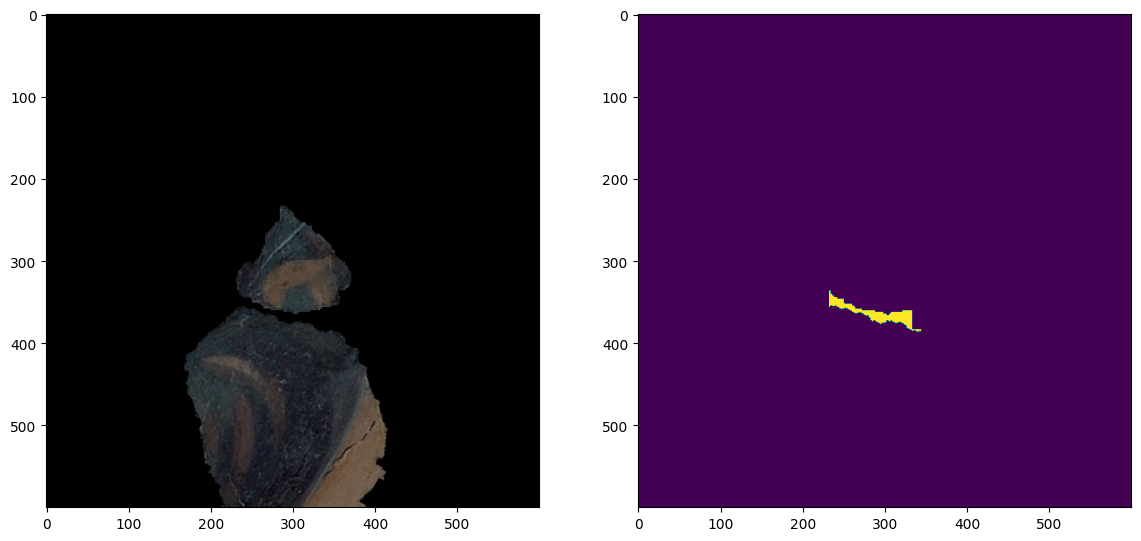

In [61]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
axes[0].imshow(blended.fragment)
axes[1].imshow(gap)

In [62]:
model = load_model()

In [63]:
def inpaint_gap(two_frags, gap_mask, model):
    """
    two_frags: np.array, image with two fragments
    gap_mask: np.array, binary mask of the gap
    model: inpainting model

    return: np.array, inpainted image
    """
    gap_mask = cv2.dilate(gap_mask * 1.0, np.ones((5,5), np.uint8))
    return extend_image(two_frags, gap_mask[:,:,None].astype(bool), model)

In [64]:
inpainted = inpaint_gap(blended.fragment * 255, gap, model)

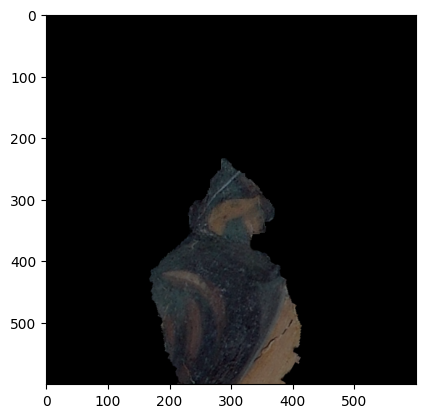

In [65]:
plt.imshow(inpainted)